In [1]:
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
import os
import cv2
import shutil
import random

def preprocess_images(input_folder, output_folder, image_size=(128, 128), test_ratio=0.2):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create train and test folders
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate over subfolders
    for class_name in os.listdir(input_folder):
        class_input_folder = os.path.join(input_folder, class_name)
        class_output_folder_train = os.path.join(train_folder, class_name)
        class_output_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_output_folder_train, exist_ok=True)
        os.makedirs(class_output_folder_test, exist_ok=True)

        # Iterate over images in the subfolder
        images = os.listdir(class_input_folder)
        random.shuffle(images)
        num_test_images = int(len(images) * test_ratio)
        test_images = images[:num_test_images]
        train_images = images[num_test_images:]

        for image_name in train_images:
            image_path = os.path.join(class_input_folder, image_name)
            output_image_path = os.path.join(class_output_folder_train, image_name)
            preprocess_and_save(image_path, output_image_path, image_size)

        for image_name in test_images:
            image_path = os.path.join(class_input_folder, image_name)
            output_image_path = os.path.join(class_output_folder_test, image_name)
            preprocess_and_save(image_path, output_image_path, image_size)

def preprocess_and_save(input_image_path, output_image_path, image_size):
    # Read and resize the image
    image = cv2.imread(input_image_path)
    if image is not None:
        image = cv2.resize(image, image_size)

        # # Convert to grayscale
        # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Save the preprocessed image
        cv2.imwrite(output_image_path, image)

# Example usage:
input_folder = r"U:\GLCM\dataset\rice leaf diseases dataset" # Path to the folder containing subfolders with images
output_folder = r"U:\GLCM\dataset\preprocessed"  # Path to the folder where preprocessed images will be saved
preprocess_images(input_folder, output_folder)


In [3]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data

def fast_glcm(img, vmin=0, vmax=255, nbit=8, kernel_size=5):
    mi, ma = vmin, vmax
    ks = kernel_size
    h,w = img.shape

    # digitize
    bins = np.linspace(mi, ma+1, nbit+1)
    gl1 = np.digitize(img, bins) - 1
    gl2 = np.append(gl1[:,1:], gl1[:,-1:], axis=1)

    # make glcm
    glcm = np.zeros((nbit, nbit, h, w), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1

    kernel = np.ones((ks, ks), dtype=np.uint8)
    for i in range(nbit):
        for j in range(nbit):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)

    glcm = glcm.astype(np.float32)
    return glcm



def fast_glcm_contrast(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm contrast
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    cont = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            cont += glcm[i,j] * (i-j)**2

    return cont


def fast_glcm_dissimilarity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm dissimilarity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    diss = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            diss += glcm[i,j] * np.abs(i-j)

    return diss


def fast_glcm_homogeneity(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm homogeneity
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    homo = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            homo += glcm[i,j] / (1.+(i-j)**2)

    return homo


def fast_glcm_ASM(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm asm, energy
    '''
    h,w = img.shape
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    asm = np.zeros((h,w), dtype=np.float32)
    for i in range(nbit):
        for j in range(nbit):
            asm  += glcm[i,j]**2

    ene = np.sqrt(asm)
    return asm, ene

def fast_glcm_entropy(img, vmin=0, vmax=255, nbit=8, ks=5):
    '''
    calc glcm entropy
    '''
    glcm = fast_glcm(img, vmin, vmax, nbit, ks)
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./ks**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    return ent




In [4]:
from skimage.color import rgb2gray

def calculate_glcm_features(images):
    features = []
    # Resize image to reduce memory usage
    
    if isinstance(images, list):  # Check if images is a list (batch processing)
        for image in images:
            h,w = image.shape   
            # glcm_mean = fast_glcm_mean(image)  
            # glcm_std = fast_glcm_std(image)
            glcm_contrast = fast_glcm_contrast(image)
            glcm_dissimilarity = fast_glcm_dissimilarity(image)
            glcm_homogeneity = fast_glcm_homogeneity(image)
            glcm_asm, glcm_energy = fast_glcm_ASM(image)
            # glcm_max = fast_glcm_max(image)
            glcm_entropy = fast_glcm_entropy(image)

            features = np.concatenate([  glcm_contrast.ravel(),
                                    glcm_dissimilarity.ravel(), glcm_homogeneity.ravel(),
                                     glcm_energy.ravel(),
                                    glcm_entropy.ravel()])
            pass
    else:
        h,w = images.shape
        glcm_contrast = fast_glcm_contrast(images)
        glcm_dissimilarity = fast_glcm_dissimilarity(images)
        glcm_homogeneity = fast_glcm_homogeneity(images)
        glcm_asm, glcm_energy = fast_glcm_ASM(images)
        glcm_entropy = fast_glcm_entropy(images)

        features = np.concatenate([ glcm_contrast.ravel(),
                                glcm_dissimilarity.ravel(), glcm_homogeneity.ravel(),
                                 glcm_energy.ravel(),
                                glcm_entropy.ravel()])
        pass
    #fs=16
    # plt.subplot(2,5,4)
    # plt.tick_params(labelbottom=False, labelleft=False)
    # plt.imshow(glcm_contrast)
    # plt.title('contrast', fontsize=fs)

    # plt.subplot(2,5,5)
    # plt.tick_params(labelbottom=False, labelleft=False)
    # plt.imshow(glcm_dissimilarity)
    # plt.title('dissimilarity', fontsize=fs)

    # plt.subplot(2,5,6)
    # plt.tick_params(labelbottom=False, labelleft=False)
    # plt.imshow(glcm_homogeneity)
    # plt.title('homogeneity', fontsize=fs)

    # plt.subplot(2,5,8)
    # plt.tick_params(labelbottom=False, labelleft=False)
    # plt.imshow(glcm_energy)
    # plt.title('energy', fontsize=fs)

    # plt.subplot(2,5,10)
    # plt.tick_params(labelbottom=False, labelleft=False)
    # plt.imshow(glcm_entropy)
    # plt.title('entropy', fontsize=fs)

    return np.array(features)



In [5]:
def load_images_from_folder(folder):
    images = []
    labels = []
    label_mapping = {}  # Dictionary to map folder names to numeric labels
    for i, subfolder in enumerate(os.listdir(folder)):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            label_mapping[subfolder] = i  # Map folder name to numeric label
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                if img_path.endswith(".jpg") or img_path.endswith(".JPG"):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(i)  # Use numeric label from mapping
    print(labels)
    return images, labels


In [6]:

# Load images and labels from train and test folders
train_folder_path = r"U:\GLCM\dataset\preprocessed\train"
test_folder_path = r"U:\GLCM\dataset\preprocessed\test"
X_train, y_train = load_images_from_folder(train_folder_path)
X_test, y_test = load_images_from_folder(test_folder_path)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [7]:
# Calculate GLCM features for train and test images
X_train_features = np.array([calculate_glcm_features(image) for image in X_train])
X_test_features = np.array([calculate_glcm_features(image) for image in X_test])
# Reshape the input data to 4D tensor

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import joblib
from sklearn import svm
from sklearn.model_selection import train_test_split

# Assuming X_train_features contains GLCM features and y_train contains corresponding labels
# X_train_features and X_test_features should be in the shape (n_samples, n_features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)

# Initialize SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)

# Predict labels for test data
y_pred = clf.predict(X_test)

# Calculate evaluation metrics for the whole model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Get the distance of each sample from the decision boundary
decision_function = clf.decision_function(X_test)
confidence_scores = np.abs(decision_function) / np.linalg.norm(clf.coef_)

# Compute confusion matrix for the whole model
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate per-class metrics
class_precision = precision_score(y_test, y_pred, average=None)
class_recall = recall_score(y_test, y_pred, average=None)
class_f1 = f1_score(y_test, y_pred, average=None)

print("SVM Results (Whole Model):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confidence Scores:", confidence_scores)
print("Confusion Matrix:")
print(conf_matrix)

# Print per-class metrics
print("\nPer-Class Metrics:")
for i in range(len(class_precision)):
    print(f"Class {i}: Precision={class_precision[i]}, Recall={class_recall[i]}, F1-Score={class_f1[i]}")

# Save the trained model to a file
joblib.dump(clf, 'svm_model22.pkl')


SVM Results (Whole Model):
Accuracy: 0.9431396786155748
Precision: 0.942549238201412
Recall: 0.9439187144491119
F1 Score: 0.9428867009647792
Confidence Scores: [[15.15082394  3.31361906 32.51491664]
 [33.17221047  4.20437745 17.99057951]
 [ 3.75154264 32.54795063 17.36069419]
 ...
 [17.36991005  3.76937196 32.57852902]
 [ 2.86702728 12.85385521 32.51478393]
 [15.64310203  3.69204086 32.87495522]]
Confusion Matrix:
[[267   8  15]
 [  3 259   8]
 [  6   6 237]]

Per-Class Metrics:
Class 0: Precision=0.967391304347826, Recall=0.9206896551724137, F1-Score=0.9434628975265018
Class 1: Precision=0.9487179487179487, Recall=0.9592592592592593, F1-Score=0.9539594843462247
Class 2: Precision=0.9115384615384615, Recall=0.9518072289156626, F1-Score=0.931237721021611


['svm_model22.pkl']

Predicted class for the new image: 1


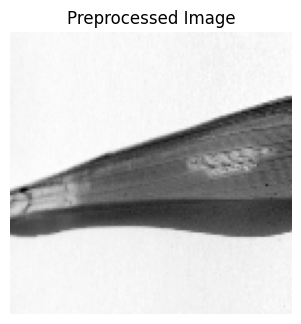

In [9]:
import numpy as np
import joblib
from PIL import Image
import cv2

# Load the saved model
loaded_model = joblib.load('svm_model22.pkl')
new_image_path = r"C:\Users\nitro\Desktop\svm\dataset\Ricedisease\Bacterial leaf blight\DSC_0373.jpg"
new_img = np.array(Image.open(new_image_path).convert('L'))
image_size = (128, 128)
resizedimage = cv2.resize(new_img, image_size)
new_image_features = calculate_glcm_features(resizedimage)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(resizedimage, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')
# Use the trained model to predict the class of the new image
predicted_class = loaded_model.predict([new_image_features])[0]
print("Predicted class for the new image:", predicted_class)
